# CML wet/dry detection

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import modul.cnn as cnn

import xarray as xr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output

#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step [mm/5 min]

In [4]:
# Path averaged reference RADOLAN data aligned with all 500 CML IDs with 5 min time step
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set = ref_set.rename_vars({'rainfall_amount':'rain'})

## CML data preprocessing
1. replacing fault values
3. calculating TRSL
4. Interpolation  

pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### CML: Repair fault data and calculate TRSL

In [5]:
cml_set['tsl'] = cml_set.tsl.where(cml_set.tsl != 255.0)
cml_set['rsl'] = cml_set.rsl.where(cml_set.rsl != -99.9)
cml_set['trsl'] = cml_set.tsl - cml_set.rsl
cml_set['trsl'] = cml_set.trsl.interpolate_na(dim='time', method='linear', max_gap='60min')

cml_set = cml_set.transpose('cml_id', 'channel_id', 'time')

#### RADOLAN: Repair fault data, resample to 10 min, sum rain rate to mm/10min, create bool W/D

In [6]:
ref_set['rain'] = ref_set.rain.interpolate_na(dim='time', method='linear', max_gap='20min')

# resample to intended sample size 10 min
ref_set = ref_set.resample(time="10min").sum()

ref_set = ref_set.transpose('cml_id', 'time')

# From reference rain rate derivate boolean reference Wet/Dry signal
ref_set['ref_wd'] = ref_set.rain.where(ref_set.rain == 0, True).astype(bool)

#### Plot one cml of dataset

Text(0.5, 1.0, '')

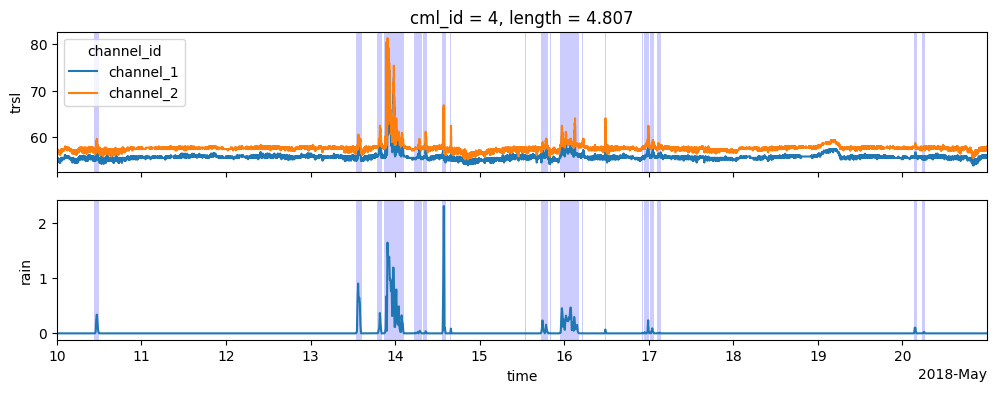

In [9]:
# select one cml:
k = 4
my_cml = cml_set.isel(cml_id = k)
my_ref = ref_set.isel(cml_id = k)

# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
my_ref['ref_wd'][0] = False
#my_ref['ref_wd'][-1] = False

# setup figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
#ax1 = axs[0].twiny()
#fig.tight_layout()

# plot TRSL
my_cml.trsl.plot.line(x='time', ax=axs[0], label = 'TL');
# plot Rain rate 
my_ref.rain.plot.line(x='time', ax=axs[1], label = 'TL');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wd, -1) & ~my_ref.ref_wd
wet_end = np.roll(my_ref.ref_wd, 1) & ~my_ref.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    axs[0].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   

# axes limits source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
axs[1].set_xlim(my_cml.time.values[0], my_cml.time.values[-1])
axs[0].set_xlabel('')
axs[1].set_title("")


#### <span style="color:red">TODO: </span>Detect higher fault periods

## Building dataset
1. creating dataset of training and reference data + data visualisation
2. Standardising

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

#### Agregate 10min measurements into sample
To build samples for CNN. rain event will be predicted for whole sample
10 times 1 min time step = 10min time window   
source: chatGPT

__TODO: Possible simplification using .reshape or .view and rewriting trsl, ref_wd__

In [9]:
# extract metadata:
'''
cml_id = my_cml.cml_id.values
length = my_cml.length.values
frequency = my_cml.frequency.values
polarization = my_cml.polarization.values
'''

'\ncml_id = my_cml.cml_id.values\nlength = my_cml.length.values\nfrequency = my_cml.frequency.values\npolarization = my_cml.polarization.values\n'

In [11]:
sample_size = 10 # = minutes
# get number of samples 
n_samples = len(cml_set.time) // sample_size 
# last few points cant make a sample of full length. Will be cut off.
cutoff = len(cml_set.time)-n_samples*sample_size
n_samples

1584

In [12]:
# Reshape dataset to a new shape with the sample_id dimension 
trsl_reshaped = cml_set['trsl'].values[:,:,:(n_samples*sample_size)].reshape(500,2, n_samples, sample_size)

# reshape and add vector of time into dataset to remember the time stamp
time_reshaped = cml_set['time'].values[:(n_samples*sample_size)].reshape(n_samples, sample_size)

In [13]:
# how many cmls include into dataset
num_cmls = 5

In [14]:
# Create a new xarray Dataset with sample_num as a dimension
# replace time and date with timestep in the time sample
ds = xr.Dataset({
    'trsl': (('cml_id', 'channel_id', 'sample_num', 'timestep'), trsl_reshaped[:num_cmls]),
    'rain': (('cml_id', 'sample_num'), ref_set['rain'].values[:num_cmls,:(n_samples*sample_size)]),
    'ref_wd': (('cml_id', 'sample_num'), ref_set['ref_wd'].values[:num_cmls,:(n_samples*sample_size)]),
    'time': (('sample_num', 'timestep'), time_reshaped)
}, coords={'cml_id': np.arange(num_cmls),
           'channel_id': np.arange(2),
           'sample_num': np.arange(n_samples),
           'timestep': np.arange(sample_size)#,
           #'length': length,                                  #single value is never a dimension
           #'frequency': (('channel_id'), frequency),          # this way coordinate will not become a dimension
           #'polarization': (('channel_id'), polarization)
           })

#### Plot dataset of the one chosen cml 

#### Standardising
"Subtracting the median of all available data from the preceding 72h from each time step."[2]   

Method: divide all trsl points with the median value for specified channell

In [33]:
ds = ds.reset_coords(['trsl_st'], drop=True)

In [36]:
# Calculate median and divide trsl for both channels
#median_tot = ds.trsl.median(axis=(1,2), skipna=True)
#ds['trsl'] = ds.trsl / median_tot

# Init. ds variable
ds['trsl_st'] = ds.trsl

# Standardising to 0-1 fullscale
for i in range(num_cmls):
    ds['trsl_st'][i] = (ds.trsl[i] - ds.trsl[i].min(skipna=True)) / (ds.trsl[i].max(skipna=True) - ds.trsl[i].min(skipna=True))

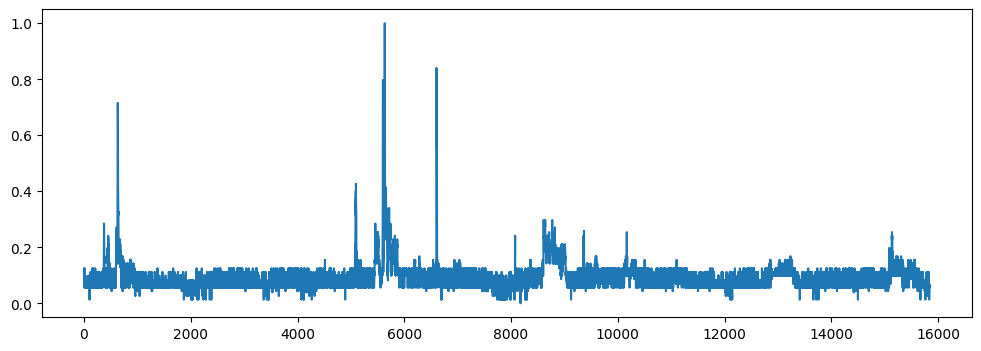

In [60]:
# select one cml:

# setup figure
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(12,4))

axs.plot(ds.trsl_st.isel(cml_id=1,channel_id=1).values.reshape(-1))



#### Training/Testing data splitting + converting to tensors
<span style="color:red">TODO: </span>add validation data: 1 cml  
https://github.com/jpolz/cml_wd_pytorch/blob/main/wd_pytorch/train_cnn.ipynb [2]

In [41]:
# for tensors we need to make dataset 3D and make sample_num the first dimension
ds['trsl_st'] = ds.trsl_st.transpose('cml_id', 'sample_num', 'channel_id', 'timestep')

# remove sample id coordinate and reshape to 3D
trsl = ds.trsl_st.values.reshape(num_cmls*n_samples,2 , sample_size)
ref = ds.ref_wd.values.reshape(num_cmls*n_samples)

In [42]:
batchsize = 10
k_train = 0.8     # fraction of training data

train_size = int(len(trsl)*k_train/batchsize)* batchsize
train_size

6330

Shuffling data disabled, splitting and turning to arrays

In [43]:
train_data = trsl[:train_size]
test_data = trsl[train_size:]
train_ref = ref[:train_size]
test_ref = ref[train_size:]

Storing as tensors [2]

In [44]:
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)

train_ref = torch.Tensor(train_ref)
test_ref = torch.Tensor(test_ref)

Turning into dataset, shuffling

In [45]:
dataset = torch.utils.data.TensorDataset(train_data, train_ref)
testset = torch.utils.data.TensorDataset(test_data, test_ref)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = False)    # shuffle the training data, once more? True
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)

## Training the CNN

In [46]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# try lower training rate and no dropout


In [68]:
epochs = 100    # experimentally max epochs: 30, overfitting around 15
resume = 60     # continue learning at epoch xx 
# Low epochs make cnn output low? around 0.5 max

In [69]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

99

train loss: 0.25555247
test loss: 0.24560815
min test loss: 0.24021809


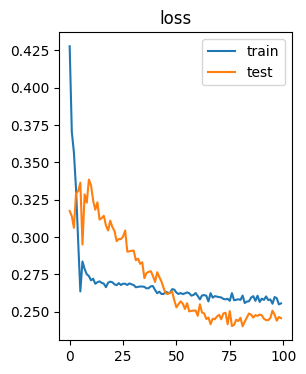

In [70]:
for epoch in range(resume, epochs):
    # training
    cnn_prediction = []
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)            # transpose column data into row
        # calculating the loss function

        # getting the output
        if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
                
        loss = nn.BCELoss()(pred, targets)      # Targets and Imputs size must match
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))

    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            
            # getting the output
            if epoch == epochs-1: cnn_prediction = cnn_prediction+pred.tolist()
                
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

## Data validation
prediction output, confusion matrix, MCC...
#### Plot the prediction output
#### <span style="color:red">TODO: </span>Add Legends to figures

In [71]:
ds['cnn_out'] = (('sample_num'), np.array(cnn_prediction[:1584]))
cnn_wd_threshold = 0.5

ds['cnn_wd'] = (('sample_num'), ds.cnn_out.values > cnn_wd_threshold)

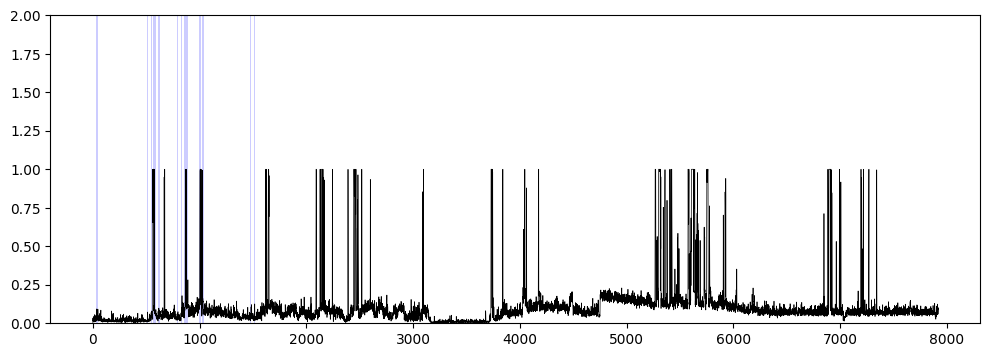

In [72]:
fig, ax = plt.subplots(figsize=(12,4), sharex=True)

#ds['ref_wd'][0,0] = False
#ds['ref_wd'][0,-1] = False

#ax.set_xlim(0,1584)
ax.set_ylim(0,2);

ax.plot(cnn_prediction[:], color='black', lw=0.5)

wet_start = np.roll(ds.ref_wd[0], -1) & ~ds.ref_wd[0]
wet_end = np.roll(ds.ref_wd[0], 1) & ~ds.ref_wd[0]
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    

In [73]:
# predicted true wet
ds['true_wet'] = ds.cnn_wd & ds.ref_wd[0] 
# cnn false alarm
ds['false_alarm'] = ds.cnn_wd & ~ds.ref_wd[0]
# cnn missed wet
ds['missed_wet'] = ~ds.cnn_wd & ds.ref_wd[0]

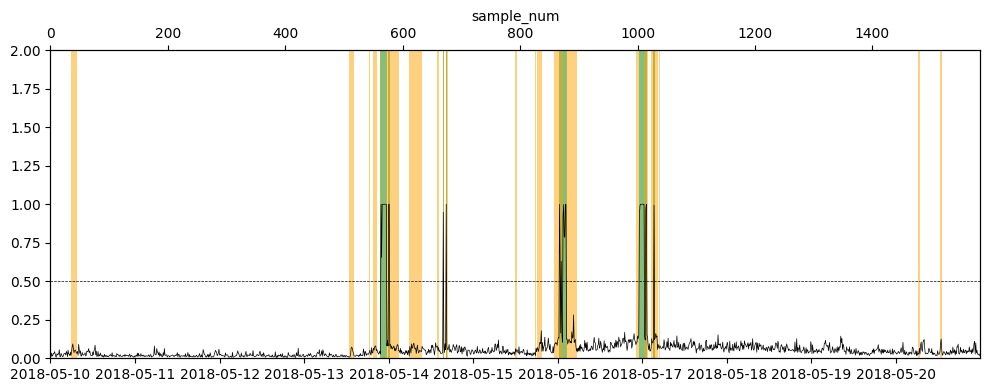

In [74]:
# setup figure
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True)
ax2 = ax1.twiny()

ax1.set_xlim(ds.time.values[0,0], ds.time.values[-1,-1])

ax2.set_xlim(0, n_samples + cutoff)
ax1.set_ylim(0,2);
ax2.set_xlabel('sample number')

# plot cnn prediction
ds.cnn_out.plot.line(x='sample_num', ax=ax2, label = 'TL',color='black', lw=0.5);

#cnn threshold
ax2.axhline(cnn_wd_threshold, color='black', linestyle='--', lw=0.5)

# GREEN: plot true cnn predicted wet/dry areas
# tip from stack ovefrolw: https://stackoverflow.com/questions/44632903/setting-multiple-axvspan-labels-as-one-element-in-legend
wet_start = np.roll(ds.true_wet, -1) & ~ds.true_wet
wet_end = np.roll(ds.true_wet, 1) & ~ds.true_wet
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='g', alpha=0.5, linewidth=0, label='_'*wet_start_i+'true wet') 

# RED: plot false alarms
wet_start = np.roll(ds.false_alarm, -1) & ~ds.false_alarm
wet_end = np.roll(ds.false_alarm, 1) & ~ds.false_alarm
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='r', alpha=0.5, linewidth=0, label='_'*wet_start_i+'false alarm') 
    
# ORANGE: plot missed wet 
wet_start = np.roll(ds.missed_wet, -1) & ~ds.missed_wet
wet_end = np.roll(ds.missed_wet, 1) & ~ds.missed_wet
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax2.axvspan(ds.sample_num.values[wet_start_i], ds.sample_num.values[wet_end_i], color='orange', alpha=0.5, linewidth=0, label='_'*wet_start_i+'missed wet')

#### ROC curve

source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb  

In [63]:
def roc_curve(y_pred, y_true, tr_start, tr_end):
    '''
    Compute the ROC curve for the CNN. The minimum threshold is tr_start and the maximum threshold is tr_end.
    '''
    roc = []
    for i in range(tr_start*1000,1+tr_end*1000,1):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)  
        true_pos = np.sum(np.logical_and(y_true==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_true==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_true==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_true==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)

def roc_surface(roc):
    '''
    Compute the Area under a ROC curve.
    '''
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

In [64]:
# ROC curve
roc = roc_curve(ds.cnn_out, ds.ref_wd, 0, 1)


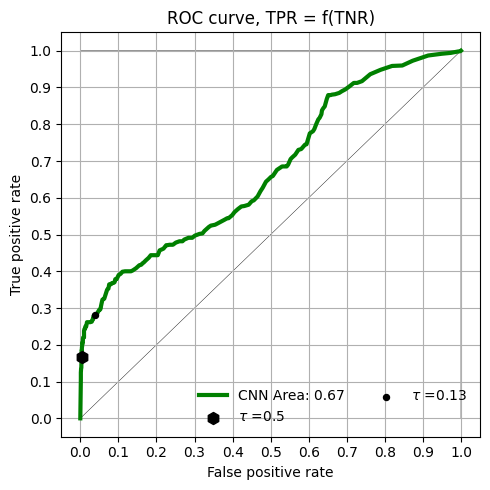

In [65]:
plt.figure(figsize=(5,5))
plt.plot(roc[:,1],roc[:,0], color='green', label='CNN Area: '+str(np.round(roc_surface(roc), decimals=2)), zorder=2, lw=3)

# plot point of cnn threshold for optimalisation
plt.scatter(roc[int(cnn_wd_threshold*1000),1],roc[int(cnn_wd_threshold*1000),0], color='black', marker='h', s=75, label='$\\tau$ ='+str(cnn_wd_threshold), zorder=3)
thr = 0.13
plt.scatter(roc[int(thr*1000),1],roc[int(thr*1000),0], color='black', marker='.', s=75, label='$\\tau$ ='+str(thr), zorder=3)

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3, zorder=1)
plt.title('ROC curve, TPR = f(TNR)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', ncol=2, frameon=False)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

#### MCC, ACC, confusion matrix
source: [2], https://github.com/jpolz/cnn_cml_wet-dry_example/blob/master/CNN_for_CML_example_nb.ipynb

In [ ]:
print('CNN scores')

# confusion matrix 
cm = skl.confusion_matrix(ds.ref_wd, ds.cnn_wd, labels=[0,1], normalize='true').round(decimals=2)
print('normalized confusion matrix:\n',cm)

print('confusion matrix:\n',skl.confusion_matrix(ds.ref_wd, ds.cnn_wd).round(decimals=2))
print('TNR:', cm[0,0])
print('TPR:', cm[1,1])

# Matthews Correlation Coeficient
mcc = skl.matthews_corrcoef(ds.ref_wd, ds.cnn_wd).round(decimals=2)
print('MCC:', mcc)

# 
acc = np.round(skl.accuracy_score(ds.ref_wd, ds.cnn_wd), decimals=2)
print('ACC:', acc)

f1 = skl.f1_score(ds.ref_wd, ds.cnn_wd).round(decimals=2)
print('F1:', f1)

# ROC curve surface
a = roc_surface(roc).round(decimals=2)
print('ROC surface A:', a)

In [ ]:
import itertools

# plot the confusion matrix
labels = ['dry', 'wet']

fig, ax1 = plt.subplots(figsize=(3,3), sharex=True)
#ax1 = fig.add_subplot(131)

cax = ax1.matshow(cm, cmap=plt.cm.Blues)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted')
plt.ylabel('True')
ax1.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('CNN', pad=50)

## Wet Antenna Attenuation
For CNN predicted wet/dry periods.  
Using modules imported from Pycomlink

#### <span style="color:red">TODO: </span>Reshape dataset back to time domain
<span style="color:red">Assuming, each reference RADOLAN rain sample taken in time TT is measurement from <TT; TT + 5min> period. </span> This assumption may itroduce up to 5min time shift between reference and CML data (TT measurement contains rather value from <TT-5min; TT>), but doesn't introduce any invasive change to the original data.  
In future RADOLAN ref values may be shifted -5 minutes.

In [ ]:
# Reshape dataset back to time domain
trsl_waa = ds['trsl'].values.reshape(2,-1)
cnn_waa = np.repeat(ds['cnn_wd'].values.reshape(-1),10)   # cnn_wd output upsampled to 1min by repeating the values 
time_waa = ds['time'].values.reshape(-1)                  # to be dimension again

In [ ]:
# Create a new xarray Dataset in time domain
# cnn_wd upsampled 10 times
ds_waa = xr.Dataset({
    'trsl': (('channel_id', 'time'), trsl_waa),
    'cnn_wd': (('time'), cnn_waa)
}, coords={'channel_id': np.arange(2),
           'time': time_waa,
           'cml_id': cml_id,
           'length': length,                                  #single value is never a dimension
           'frequency': (('channel_id'), frequency),          # this way coordinate will not become a dimension
           'polarization': (('channel_id'), polarization)
           })

#### CML baseline for CNN predicted Wet signal calculated with Pycomlink modul

In [ ]:
import pycomlink as pycml

ds_waa['baseline'] = pycml.processing.baseline.baseline_constant(trsl=ds_waa.trsl, wet=ds_waa.cnn_wd, n_average_last_dry=5)

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))

ds_waa.trsl.sel(time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)  # reuse plot colors
ds_waa.baseline.sel(time=slice('2018-05-13T12:00', '2018-05-14T06:00')).plot.line(x='time');
plt.ylabel('TRSL');

#### Wet antenna attenuation estimation
from Pyomlink using Schleiss 2013. mathematical model

In [ ]:
ds_waa['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_waa.trsl, 
    baseline=ds_waa.baseline, 
    wet=ds_waa.cnn_wd, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [ ]:
ds_waa['baseline_waa_c'] = ds_waa.baseline + ds_waa.waa
ds_waa['rain_att'] = ds_waa.trsl - ds_waa.baseline_waa_c
ds_waa['rain_att'].values[ds_waa.rain_att < 0] = 0

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

plt.sca(axs[0])
ds_waa.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(None)
ds_waa.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
plt.gca().set_prop_cycle(None)
ds_waa.baseline_waa_c.isel(channel_id=0).plot.line(x='time', label='baseline with WAA correction');
plt.ylabel('TRSL [dB]')
axs[0].legend()


plt.sca(axs[1])
(ds_waa.trsl-ds_waa.baseline).isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA cor');
plt.gca().set_prop_cycle(None)
ds_waa.rain_att.isel(channel_id=0).plot.line(x='time', label='with WAA');
plt.ylabel('rain induced ATT [dB]');
axs[1].set_title('');
axs[1].legend()

axs[1].set_xlim(pd.to_datetime('2018-05-13T12:00'), pd.to_datetime('2018-05-14T06:00'));

#### Rain rate estimation using kR relation

In [ ]:
ds_waa['r_est'] = pycml.processing.k_R_relation.calc_R_from_A(A=ds_waa.rain_att, 
                                                              L_km=float(ds_waa.length), 
                                                              f_GHz=ds_waa.frequency/1e9, 
                                                              pol=ds_waa.polarization)

In [ ]:
# note: 
#     Reference 1h rainfall rate sampled to 5 min has to be converted to 5min rain rate ... multiplied by 60/5 min
#     CML rain rate will be resampled to 5 min 


fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
ds_waa.trsl.plot.line(x='time', ax=axs[0])
plt.ylabel('trsl [dB]');

ds_waa.r_est.resample(time="5min").mean().plot.line(x='time', ax=axs[1])
(my_ref.rain*12).plot.line(x='time', ax=axs[1], color='black', lw=0.5, label='ref RADOLAN rainrate')
plt.ylabel('rain rate [mm/h]');

axs[1].set_xlim(pd.to_datetime('2018-05-13T12:00'), pd.to_datetime('2018-05-14T06:00'));
axs[1].set_title('');
axs[1].legend();

### ____________________________________________________________________________________________________________

original validation [2]:

In [ ]:
for inputs, targets in tqdm(trainloader):
    print(nn.Flatten(0,1)(model(inputs)))
    print(targets)
    break

In [ ]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor, predictions

In [ ]:
eval_model(testloader, model)

### rolling standard deviation classification for reference

In [ ]:
threshold = 0.8

roll_std_dev = my_cml.trsl.rolling(time=60, center=True).std()
my_cml['rsd_wet'] = my_cml.trsl.rolling(time=60, center=True).std() > threshold

In [ ]:
my_cml

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

my_cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(my_cml.rsd_wet, -1) & ~my_cml.rsd_wet
wet_end = np.roll(my_cml.rsd_wet, 1) & ~my_cml.rsd_wet

# Plot shaded area for each RSD predicted wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(my_cml.time.values[wet_start_i], my_cml.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0)

axs[1].set_title('');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wet_dry, -1) & ~my_ref.ref_wet_dry
wet_end = np.roll(my_ref.ref_wet_dry, 1) & ~my_ref.ref_wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wet_dry.time.values[wet_end_i], color='g', alpha=0.2, linewidth=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html